In [23]:
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import PIL
import scipy.linalg
from sklearn.cross_decomposition import PLSRegression 
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.ticker import MaxNLocator
from qpfs import *
from kernels import *
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
from tensorly.decomposition import robust_pca

In [22]:
i1 = PIL.Image.open(f'BerkeleyMHAD/Cam1/R01/img_l01_c01_s01_a01_r01_00018.pgm')
i1 = i1.crop((230,100,380,450))
i1 = i1.resize((30,70),PIL.Image.ANTIALIAS)
i1.show()

In [46]:
Y1 = pd.read_csv('BerkeleyMHAD/acc_h01_s01_a01_r01.csv').values.reshape(182,4,1)
Y2 = pd.read_csv('BerkeleyMHAD/acc_h02_s01_a01_r01.csv').iloc[1:,:3].values.reshape(180,3,1)
Y3 = pd.read_csv('BerkeleyMHAD/acc_h03_s01_a01_r01.csv').iloc[1:,:3].values.reshape(180,3,1)
Y4 = pd.read_csv('BerkeleyMHAD/acc_h04_s01_a01_r01.csv').iloc[1:,:3].values.reshape(180,3,1)
Y5 = pd.read_csv('BerkeleyMHAD/acc_h05_s01_a01_r01.csv').iloc[1:,:3].values.reshape(180,3,1)
Y6 = pd.read_csv('BerkeleyMHAD/acc_h06_s01_a01_r01.csv').iloc[:,:3].values.reshape(180,3,1)
Y_t = np.concatenate((Y1[2:,:3,:],Y2,Y3,Y4,Y5,Y6),axis=2)
X1 = PIL.Image.open(f'BerkeleyMHAD/Cam1/R01/img_l01_c01_s01_a01_r01_00000.pgm')
X2 = PIL.Image.open(f'BerkeleyMHAD/Cam2/R01/img_l02_c01_s01_a01_r01_00000.pgm')
X3 = PIL.Image.open(f'BerkeleyMHAD/Cam3/R01/img_l03_c01_s01_a01_r01_00000.pgm')
X4 = PIL.Image.open(f'BerkeleyMHAD/Cam4/R01/img_l04_c01_s01_a01_r01_00000.pgm')
X1 = X1.crop((210,30,450,470))
X1 = X1.resize((30,55),PIL.Image.ANTIALIAS)
X2 = X2.crop((210,30,450,470))
X2 = X2.resize((30,55),PIL.Image.ANTIALIAS)
X3 = X3.crop((210,30,450,470))
X3 = X3.resize((30,55),PIL.Image.ANTIALIAS)
X4 = X4.crop((210,30,450,470))
X4 = X4.resize((30,55),PIL.Image.ANTIALIAS)
X4.show()
X1.show()
X2.show()
X3.show()
X1 = np.array(X1).reshape(55,30,1)
X2 = np.array(X2).reshape(55,30,1)
X3 = np.array(X3).reshape(55,30,1)
X4 = np.array(X4).reshape(55,30,1)
X_t = np.concatenate((X1,X2,X3,X4), axis=2).reshape(1,55,30,4)
for i in range(1,126):
    if i < 10:
        n = '00'+str(i)
    elif i < 100:
        n = '0'+str(i)
    else:
        n = str(i)
    X1 = PIL.Image.open(f'BerkeleyMHAD/Cam1/R01/img_l01_c01_s01_a01_r01_00{n}.pgm')
    X2 = PIL.Image.open(f'BerkeleyMHAD/Cam2/R01/img_l02_c01_s01_a01_r01_00{n}.pgm')
    X3 = PIL.Image.open(f'BerkeleyMHAD/Cam3/R01/img_l03_c01_s01_a01_r01_00{n}.pgm')
    X4 = PIL.Image.open(f'BerkeleyMHAD/Cam4/R01/img_l04_c01_s01_a01_r01_00{n}.pgm')
    X1 = X1.crop((210,30,450,470))
    X1 = X1.resize((30,55),PIL.Image.ANTIALIAS)
    X2 = X2.crop((210,30,450,470))
    X2 = X2.resize((30,55),PIL.Image.ANTIALIAS)
    X3 = X3.crop((210,30,450,470))
    X3 = X3.resize((30,55),PIL.Image.ANTIALIAS)
    X4 = X4.crop((210,30,450,470))
    X4 = X4.resize((30,55),PIL.Image.ANTIALIAS)
    X1 = np.array(X1).reshape(55,30,1)
    X2 = np.array(X2).reshape(55,30,1)
    X3 = np.array(X3).reshape(55,30,1)
    X4 = np.array(X4).reshape(55,30,1)
    X_t = np.concatenate((X_t,np.concatenate((X1,X2,X3,X4), axis=2).reshape(1,55,30,4)),axis=0)

In [47]:
img_time = pd.read_csv('berkeleyMHAD/time_stamps_img_s01_a01_r01.csv').values[:,1]
Y_time = Y1[2:,3]
Y_ = np.zeros((126,3,6))

In [49]:
ind = []
for i in range(125):
    if i == 0:
        time0= img_time[i]-0.01
    else:
        time0 = img_time[i-1]
    time1 = img_time[i]
    sep = (time1-time0)/2
    if np.where((Y_time <= img_time[i]+sep)&(Y_time >= img_time[i]-sep))[0].shape[0] == 0:
        ind.append(i)
    Y_[i] = Y_t[np.where((Y_time <= img_time[i]+sep)&(Y_time >= img_time[i]-sep))[0],:,:].mean()  

In [50]:
Y_t = Y_
Y_t = np.delete(Y_t,ind,axis=0)
X_t = np.delete(X_t,ind,axis=0)

In [24]:
Y_t = np.load('Y_for_image.npy')
X_t = np.load('X_image.npy')
Y_m = Y_t.reshape(Y_t.shape[0],-1)
X_m = X_t.reshape(X_t.shape[0],-1)

In [25]:
print('Shape of matrix of features:', X_m.shape)
print('Shape of tensor of features:', X_t.shape)
print('Shape of matrix of targets:', Y_m.shape)
print('Shape of tensor of targets:', Y_t.shape)

Shape of matrix of features: (956, 2100)
Shape of tensor of features: (956, 35, 15, 4)
Shape of matrix of targets: (956, 18)
Shape of tensor of targets: (956, 3, 6)


In [26]:
X_m = (X_m - X_m.mean(axis=0))
X_t = (X_t - X_t.mean(axis=0))
Y_m = (Y_m - Y_m.mean(axis=0)) / Y_m.std(axis=0)
Y_t = (Y_t - Y_t.mean(axis=0)) / Y_t.std(axis=0)
X_m_train, X_m_test = X_m[:83,:], X_m[83:,:]
Y_m_train, Y_m_test = Y_m[:83,:], Y_m[83:,:]
X_t_train, X_t_test = X_t[:83,:,:], X_t[83:,:,:]
Y_t_train, Y_t_test = Y_t[:83,:], Y_t[83:,:,:]

In [27]:
np.isnan(Y_m).any()

False

## PLS

In [28]:
def get_autoreg_Y(Y, step=1):
    if len(Y.shape) == 2:
        m, t = Y.shape
        ar = np.zeros((m - step + 1, t * step))
        for i in range(step):
            for k in range(t):
                ar[:, i * t + k] = Y[i: m + i - step + 1, k]
    else:
        m, t, n = Y.shape
        ar = np.zeros((m - step + 1, t * step, n))
        for i in range(step):
            for k in range(t):
                for j in range(n):
                    ar[:, i * t + k,j] = Y[i: m + i - step + 1, k,j]

    return ar

def get_bootstrap(X, Y):
    n = X.shape[0]
    idxs = np.random.choice(np.arange(n), size=n)
    return X[idxs], Y[idxs]

In [29]:
def RMSE(Y_pred,Y):
    Y_base = Y.mean(axis=0)
    return np.mean(np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0)) / np.sqrt(np.mean((Y - Y_base) ** 2, axis=0)))

def q2_m(y_true,y_pred):
    return 1 - ((np.linalg.norm(y_true - y_pred) ** 2) / (np.linalg.norm(y_true) ** 2))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.28it/s]


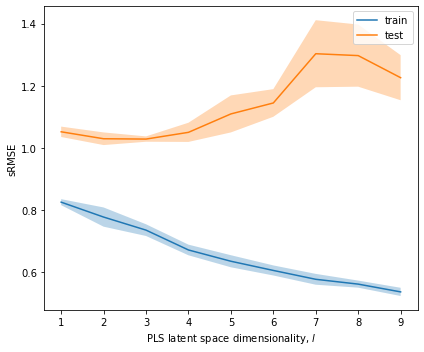

3 components with nRMSE = 1.0282651056677756


In [30]:
step = 3
n_restarts = 5

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_m_train, step), get_autoreg_Y(Y_m_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]

rmse = []
for k in tqdm(range(1, 10)):
    pls = PLSRegression(n_components=k)
    tr = []
    te = []
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        pls.fit(X, Y)
        tr.append(metric_nmse(X, Y, pls))
        te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    rmse.append((k, tr, te))
    
x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_PLS.pdf', format='pdf')
plt.show()
    
print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))

In [31]:
from time import time
start = time()
pls = PLSRegression(n_components=np.argmin(np.array(y2_mean))+1)
tr = []
te = []
for i in range(n_restarts):
    X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
    pls.fit(X, Y)
    tr.append(metric_nmse(X, Y, pls))
    te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
end = time()
PLS_time = end-start
PLS_rmse_test = np.mean(te)
PLS_rmse_train = np.mean(tr)
PLS_rmse_test_std = np.std(te)
PLS_rmse_train_std = np.std(te)
print('Time:', PLS_time)
print('Train rmse:', PLS_rmse_train,'±',PLS_rmse_train_std)
print('Test rmse:', PLS_rmse_test,'±',PLS_rmse_test_std)

Time: 0.1602036952972412
Train rmse: 0.7405763323260027 ± 0.042770590654011134
Test rmse: 1.0322353552343095 ± 0.042770590654011134


## QPFS + PLS

In [32]:
n_samples, n_features = X_m_train.shape
qpfs = QPFS()
mqpfs = MultivariateQPFS()
steps = [3, 5, 7]
n_restarts = 3
modes = ['RelAgg','AsymImp']

for step in steps:
    Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_m_train, step), get_autoreg_Y(Y_m_test, step)
    Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]
    print('step', step)
    print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

    qpfs.fit(Xtrain_ar, Ytrain_ar)
    
    score_history = [qpfs.zx]
    
    mqpfs.get_params(Xtrain_ar, Ytrain_ar)
    for mode in modes[1:]:
        alphas = mqpfs.get_alpha(mode)
        mqpfs.solve_problem(alphas, mode)
        score_history.append(mqpfs.zx)
    
    n_active_array = np.arange(1, n_features // 2, 10)
    
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        results = get_metrics(n_active_array, modes, score_history, 
                              X, Y, Xtest_ar, Ytest_ar)

step 3
(81, 54) (81, 2100) (871, 54) (871, 2100)
step 5
(79, 90) (79, 2100) (869, 90) (869, 2100)
step 7
(77, 126) (77, 2100) (867, 126) (867, 2100)


In [33]:
from itertools import combinations
lr = LinearRegression()
step = 3
n_restarts = 3

modes = ['RelAgg', 'AsymImp']

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_m_train, step), get_autoreg_Y(Y_m_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]

for i in range(1,2):
    print(modes[i])
    sh = [np.array(s)[:n_features] for s in score_history]
    corrs = []
    l2s = []
    l1s = []
    comps = []
    hams = []
    rmse = []
    for s1, s2 in combinations(sh, 2):
        corrs.append(sc.stats.spearmanr(s1, s2)[0])
        l2s.append(np.sqrt(np.sum((s1 - s2) ** 2)))
        l1s.append(np.sum(np.abs(s1 - s2)))
        hams.append(sc.spatial.distance.hamming(s1 > 1e-3, s2 > 1e-3))
        
    for s1 in sh:
        comps.append(np.sum(s1 > 1e-6))
        active_idxs = s1.argsort()[::-1][:100]#[:np.sum(s1 > 1e-3)]
        lr.fit(Xtrain_ar[:, active_idxs], Ytrain_ar)
        rmse.append(metric_rmse(Xtest_ar[:, active_idxs], Ytest_ar, lr))
    mean_corr = np.mean(corrs)
    std_corr = np.std(corrs)
    
    mean_l2 = np.mean(l2s)
    std_l2 = np.std(l2s)
    
    mean_l1 = np.mean(l1s)
    std_l1 = np.std(l1s)
    
    mean_comp = np.mean(comps)
    std_comp = np.std(comps)
    
    mean_ham = np.mean(hams)
    std_ham = np.std(hams)
    
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)
    
    print(f'corr {mean_corr:.3f} $\pm$ {std_corr:.3f}')
    print(f'l2 {mean_l2:.3f} $\pm$ {std_l2:.3f}')
    print(f'l1 {mean_l1:.3f} $\pm$ {std_l1:.3f}')
    print(f'comp {mean_comp:.1f} $\pm$ {std_comp:.1f}')
    print(f'ham {mean_ham:.3f} $\pm$ {std_ham:.3f}')
    print(f'rmse {mean_rmse:.3f} $\pm$ {std_rmse:.3f}')
    print('-' * 80)

AsymImp
corr 0.908 $\pm$ 0.000
l2 0.011 $\pm$ 0.000
l1 0.357 $\pm$ 0.000
comp 1441.5 $\pm$ 22.5
ham 0.083 $\pm$ 0.000
rmse 16.509 $\pm$ 3.817
--------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 24.59it/s]


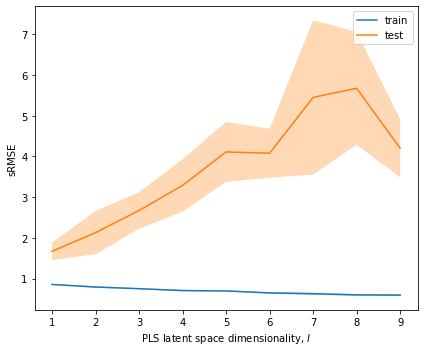

1 components with nRMSE = 1.6690999149764856


In [34]:
n_restarts = 5
step = 3

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_m_train, step), get_autoreg_Y(Y_m_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1,active_idxs], X_m_test[:X_m_test.shape[0] - step + 1,active_idxs]

rmse = []
for k in tqdm(range(1, 10)):
    pls = PLSRegression(n_components=k)
    tr = []
    te = []
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        pls.fit(X, Y)
        tr.append(metric_nmse(X, Y, pls))
        te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    rmse.append((k, tr, te))
    
x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_QPFS+PLS.pdf', format='pdf')
plt.show()
    
print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))

In [35]:
step = 3
mode = 'AsymImp'
n_samples, n_features = X_m_train.shape
Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_m_train, step), get_autoreg_Y(Y_m_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]

start = time()

qpfs.fit(Xtrain_ar, Ytrain_ar)

score_history = [qpfs.zx]

mqpfs.get_params(Xtrain_ar, Ytrain_ar)
alphas = mqpfs.get_alpha(mode)
mqpfs.solve_problem(alphas, mode)
score_history.append(mqpfs.zx)

n_active_array = np.arange(1, n_features // 2, 10)

for s1 in sh:
    comps.append(np.sum(s1 > 1e-6))
    active_idxs = s1.argsort()[::-1][:100]

Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1,active_idxs], X_m_test[:X_m_test.shape[0] - step + 1,active_idxs]
pls = PLSRegression(n_components=np.argmin(np.array(y2_mean))+1)
tr = []
te = []
for i in range(n_restarts):
    X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
    pls.fit(X, Y)
    tr.append(metric_nmse(X, Y, pls))
    te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    
end = time()
QPFS_PLS_time = end-start
QPFS_PLS_rmse_test = np.mean(te)
QPFS_PLS_rmse_train = np.mean(tr)
QPFS_PLS_rmse_test_std = np.std(te)
QPFS_PLS_rmse_train_std = np.std(te)
print('Time:', QPFS_PLS_time)
print('Train rmse:', QPFS_PLS_rmse_train,'±',QPFS_PLS_rmse_train_std)
print('Test rmse:', QPFS_PLS_rmse_test,'±',QPFS_PLS_rmse_test_std)

Time: 19.250603675842285
Train rmse: 0.8401506465603903 ± 0.2800720862124846
Test rmse: 1.6367252186694459 ± 0.2800720862124846


## HOPLS

In [39]:
from GenerateData import generateComplex
import os
import sys
import warnings
import torch
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from scipy.io import loadmat, savemat
from joblib import Parallel, delayed
from hopls import matricize, qsquared, HOPLS
import tensorly as tl

def compute_rmse_pls(tdata, tlabel, vdata, vlabel, Rval):
    test = PLSRegression(n_components=Rval,scale=False,max_iter=1000,tol=1e-5)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        test.fit(matricize(tdata), matricize(tlabel))
    Y_pred = test.predict(matricize(vdata))
    Q2 = qsquared(matricize(vlabel), matricize(Y_pred))
    return Q2

def compute_rmse_hopls(tdata, tlabel, vdata, vlabel, la, R_max=20):
    Ln = [la] * (len(tdata.shape) - 1)
    if len(tlabel.shape) > 2:
        Km = [la] * (len(tlabel.shape) - 1)
    else:
        Km = None
    test = HOPLS(R_max, Ln, Km)
    test.fit(tdata, tlabel)
    label_pred_train, r_train, _ = test.predict(tdata, tlabel)
    label_pred_test, r_test, _ = test.predict(vdata, vlabel)
    rmse_train = RMSE(label_pred_train.numpy(),tlabel.numpy())
    rmse_test = RMSE(label_pred_test.numpy(),vlabel.numpy())
    return rmse_train, rmse_test


In [40]:
RMSE_hopls = []

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_t_train, step), get_autoreg_Y(Y_t_test, step)
Xtrain_ar, Xtest_ar = X_t_train[:X_t_train.shape[0] - step + 1], X_t_test[:X_t_test.shape[0] - step + 1]
for R in range(1,81,10):
    for l in range(1,7,3):
        rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(Xtrain_ar),torch.tensor(Ytrain_ar), torch.tensor(Xtest_ar), torch.tensor(Ytest_ar),l,R)
        RMSE_hopls.append([R,l,rmse_tr,rmse_te])

In [41]:
y2_mean = np.array([r[3] for r in RMSE_hopls])
R = RMSE_hopls[np.argmin(y2_mean)][0]
l = RMSE_hopls[np.argmin(y2_mean)][1]
print('RMSE fo test:', RMSE_hopls[np.argmin(y2_mean)][3],l,R)

RMSE fo test: 0.9288043345713638 4 31


<Figure size 432x360 with 0 Axes>

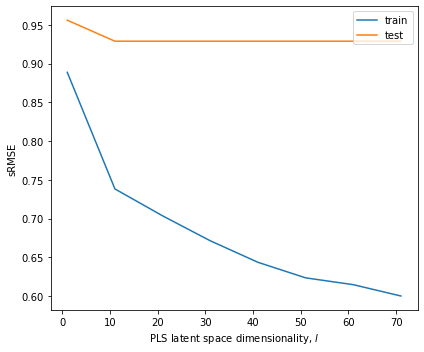

41 components with nRMSE = 0.9288043345713638


In [43]:
plt.figure(figsize=(6, 5))
x = np.array(range(1,81,10))
y1_mean = np.array([np.mean(r[2]) for r in RMSE_hopls])[np.where(np.array([r[1] for r in RMSE_hopls])==4)]
y2_mean = np.array([np.mean(r[3]) for r in RMSE_hopls])[np.where(np.array([r[1] for r in RMSE_hopls])==4)]

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')

plt.plot(x, y2_mean, label='test')
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_HOPLS.pdf', format='pdf')
plt.show()
    
print(x[np.argmin(np.array(y2_mean))+1],'components with nRMSE =', min(y2_mean))

In [44]:
from time import time
n_restarts = 5
start = time()
tr = []
te = []
for i in range(n_restarts):
    rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(Xtrain_ar),torch.tensor(Ytrain_ar), torch.tensor(Xtest_ar), torch.tensor(Ytest_ar),l,R)
    tr.append(rmse_tr)
    te.append(rmse_te)
end = time()
HOPLS_time = end-start
HOPLS_rmse_test = np.mean(te)
HOPLS_rmse_train = np.mean(tr)
HOPLS_rmse_test_std = np.std(te)
HOPLS_rmse_train_std = np.std(te)
print('Time:', HOPLS_time)
print('Train rmse:', HOPLS_rmse_train,'±',HOPLS_rmse_train_std)
print('Test rmse:', HOPLS_rmse_test,'±',HOPLS_rmse_test_std)

Time: 15.437209129333496
Train rmse: 0.6712854341731449 ± 7.021666937153402e-17
Test rmse: 0.9288043345713639 ± 7.021666937153402e-17


## 2D-PCA then PLS

In [45]:
import numpy as np
import scipy.linalg as s_linalg


class two_d_pca_class:


    def give_p(self, d):
        #print("D", d)
        sum = np.sum(d)
        sum_85 = self.p * sum
        temp = 0
        p = 0
        while temp < sum_85:
            temp += d[p]
            p += 1
        return p

    def reduce_dim(self):

        no_of_images = self.images.shape[0]
        mat_height = self.images.shape[1]
        mat_width = self.images.shape[2]
        g_t = np.zeros((mat_width, mat_width))
        h_t = np.zeros((mat_height, mat_height))

        for i in range(no_of_images):
            temp = np.dot(self.images_mean_subtracted[i].T, self.images_mean_subtracted[i])
            #print(temp.shape,g_t.shape,h_t.shape)
            g_t += temp
            h_t += np.dot(self.images_mean_subtracted[i], self.images_mean_subtracted[i].T)

        g_t /= no_of_images
        h_t /= no_of_images

        #For G_T
        d_mat, p_mat = np.linalg.eig(g_t)
        p_1 = self.give_p(d_mat)
        self.new_bases_gt = p_mat[:, 0:p_1]

        #For H_T
        d_mat, p_mat = np.linalg.eig(h_t)
        p_2 = self.give_p(d_mat)
        self.new_bases_ht = p_mat[:, 0:p_2]


        new_coordinates_temp = np.dot(self.images, self.new_bases_gt)

        self.new_coordinates = np.zeros((no_of_images, p_2, p_1))

        for i in range(no_of_images):
            self.new_coordinates[i, :, :] = np.dot(self.new_bases_ht.T, new_coordinates_temp[i])

        return self.new_coordinates


    def __init__(self, images,p):
        self.images = np.asarray(images)
        self.mean_face = np.mean(self.images, 0)
        self.p = p
        self.images_mean_subtracted = self.images - self.mean_face


    def original_data(self, new_coordinates):
        return np.dot(self.new_bases_ht, np.dot(new_coordinates, self.new_bases_gt.T))


    def new_cord_for_image(self, image):
        new_image = np.zeros((image.shape[0],self.new_bases_ht.shape[1],self.new_bases_gt.shape[1]))
        for i in range(image.shape[0]):
            new_image[i,:,:] = np.dot(self.new_bases_ht.T, np.dot(image[i,:,:], self.new_bases_gt))
        return new_image

In [47]:
n_restarts = 5
rmse = []
X_t_train_, X_t_test_ = X_t_train.reshape(X_t_train.shape[0],15,-1), X_t_test.reshape(X_t_test.shape[0],15,-1)
Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_m_train, step), get_autoreg_Y(Y_m_test, step)
Xtrain_ar, Xtest_ar = X_t_train_[:X_t_train_.shape[0] - step + 1], X_t_test_[:X_t_test_.shape[0] - step + 1]
for p in np.arange(0.95,0.999,0.005):
        pca = two_d_pca_class(Xtrain_ar,p)
        X_n_train = pca.reduce_dim().reshape(Xtrain_ar.shape[0],-1)
        X_n_test = pca.new_cord_for_image(Xtest_ar).reshape(Xtest_ar.shape[0],-1)
        for k in range(1, 4):
            pls = PLSRegression(n_components=k)
            tr = []
            te = []
            for i in range(n_restarts):
                X, Y = get_bootstrap(X_n_train, Ytrain_ar)
                pls.fit(X, Y)
                tr.append(metric_nmse(X, Y, pls))
                te.append(metric_nmse(X_n_test, Ytest_ar, pls))
            rmse.append((k, tr, te, p))

In [48]:
y2_mean = np.array([np.mean(r[2]) for r in rmse])
p = rmse[np.argmin(y2_mean)][3]
print('percentage of information:', round(p*100,2), 'RMSE fo test:', np.mean(rmse[np.argmin(y2_mean)][2]))

percentage of information: 95.0 RMSE fo test: 0.959012335656249


 14%|███████████▊                                                                       | 2/14 [00:00<00:00, 15.50it/s]

(83, 1185) (873, 1185)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  8.23it/s]


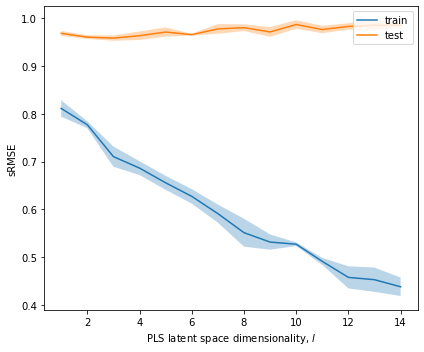

3 components with nRMSE = 0.9580936532747654


In [51]:
pca = two_d_pca_class(X_t_train_,p)
X_n_train = pca.reduce_dim().reshape(X_t_train_.shape[0],-1)
X_n_test = pca.new_cord_for_image(X_t_test_).reshape(X_t_test_.shape[0],-1)
print(X_n_train.shape,X_n_test.shape)
n_restarts = 5
step = 3

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_m_train, step), get_autoreg_Y(Y_m_test, step)
Xtrain_ar, Xtest_ar = X_n_train[:X_n_train.shape[0] - step + 1,], X_n_test[:X_n_test.shape[0] - step + 1]

rmse = []
for k in tqdm(range(1, 15)):
    pls = PLSRegression(n_components=k)
    tr = []
    te = []
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        pls.fit(X, Y)
        tr.append(metric_nmse(X, Y, pls))
        te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    rmse.append((k, tr, te))
    
x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_MPCA+PLS.pdf', format='pdf')
plt.show()
    
print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))

In [53]:
n_restarts = 5
start = time()
pca = two_d_pca_class(X_t_train_,p)
X_n_train = pca.reduce_dim().reshape(X_t_train_.shape[0],-1)
X_n_test = pca.new_cord_for_image(X_t_test_).reshape(X_t_test_.shape[0],-1)
step = 3

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_m_train, step), get_autoreg_Y(Y_m_test, step)
Xtrain_ar, Xtest_ar = X_n_train[:X_n_train.shape[0] - step + 1,], X_n_test[:X_n_test.shape[0] - step + 1]
pls = PLSRegression(n_components=np.argmin(np.array(y2_mean))+1)
tr = []
te = []
for i in range(n_restarts):
    X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
    pls.fit(X, Y)
    tr.append(metric_nmse(X, Y, pls))
    te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
end = time()
MPCA_PLS_time = end-start
MPCA_PLS_rmse_test = np.mean(te)
MPCA_PLS_rmse_train = np.mean(tr)
MPCA_PLS_rmse_test_std = np.std(te)
MPCA_PLS_rmse_train_std = np.std(te)
print('Time:', MPCA_PLS_time)
print('Train rmse:', MPCA_PLS_rmse_train,'±',MPCA_PLS_rmse_train_std)
print('Test rmse:', MPCA_PLS_rmse_test,'±',MPCA_PLS_rmse_test_std)

Time: 0.14699625968933105
Train rmse: 0.7249454860858953 ± 0.008070860393496025
Test rmse: 0.9603899909985205 ± 0.008070860393496025


## 2d-PCA + HOPLS

In [ ]:
RMSE_pca_hopls = []
Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_t_train, step), get_autoreg_Y(Y_t_test, step)
Xtrain_ar, Xtest_ar = X_t_train_[:X_t_train_.shape[0] - step + 1], X_t_test_[:X_t_test_.shape[0] - step + 1]
for p in np.arange(0.98,0.999,0.005):
        pca = two_d_pca_class(Xtrain_ar,p)
        X_n_train = pca.reduce_dim()
        X_n_test = pca.new_cord_for_image(Xtest_ar)
        for R in range(5,30,3):
            for l in range(1,10,2):
                rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(X_n_train),torch.tensor(Ytrain_ar), torch.tensor(X_n_test), torch.tensor(Ytest_ar),l,R)
                #Q_hopls.append([R,l,Q])
                RMSE_pca_hopls.append([p,R,l,rmse_tr, rmse_te])
y2_mean = np.array([r[4] for r in RMSE_pca_hopls])
p = RMSE_pca_hopls[np.argmin(y2_mean)][0]
R = RMSE_pca_hopls[np.argmin(y2_mean)][1]
l = RMSE_pca_hopls[np.argmin(y2_mean)][2]
print('Test rmse:', RMSE_pca_hopls[np.argmin(y2_mean)][4])

In [ ]:
n_restarts = 5
start = time()
pca = two_d_pca_class(X_t_train_,p)
X_n_train = pca.reduce_dim()
X_n_test = pca.new_cord_for_image(X_t_test_)
step = 3

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_t_train, step), get_autoreg_Y(Y_t_test, step)
Xtrain_ar, Xtest_ar = X_n_train[:X_n_train.shape[0] - step + 1,], X_n_test[:X_n_test.shape[0] - step + 1]
tr = []
te = []
for i in range(n_restarts):
    rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(Xtrain_ar),torch.tensor(Ytrain_ar), torch.tensor(Xtest_ar), torch.tensor(Ytest_ar),l,R)
    tr.append(rmse_tr)
    te.append(rmse_te)
end = time()
MPCA_HOPLS_time = end-start
MPCA_HOPLS_rmse_test = np.mean(te)
MPCA_HOPLS_rmse_train = np.mean(tr)
MPCA_HOPLS_rmse_test_std = np.std(te)
MPCA_HOPLS_rmse_train_std = np.std(te)
print('Time:', MPCA_HOPLS_time)
print('Train rmse:', MPCA_HOPLS_rmse_train,'±',MPCA_HOPLS_rmse_train_std)
print('Test rmse:', MPCA_HOPLS_rmse_test,'±',MPCA_HOPLS_rmse_test_std)